In [1]:
# Import manipulating files libraries
import os, glob
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
# Import graph/image plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Import loading and manipulating neuroimaging data library
import nibabel as nib

# Import array manipulating libraries
import numpy as np
import pandas as pd

# Import deep learning model libraries
import tensorflow as tf
import keras
from keras.models import Model, Sequential

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Import date/time library to save models with date/time
from datetime import datetime

In [2]:
# Get data path
data_path = 'final data/*.nii.gz'
# Find all files within the location that matches our search string
files = glob.glob(data_path)

# Get the labels for our data from our csv file
Labels = pd.read_csv('labels.csv')
# Define our target from the column "Labels" as our y in our model
target = Labels['group']

In [3]:
# Loop through files and load all data files
data_all, images = [], []
for data_file in sorted(files):
    data = nib.load(data_file).get_fdata()
    first_vol = data[:,:,:,0]
    first = first_vol / 255
    data_all.append(first)
    
# Convert our list into a numpy array
images = np.asarray(data_all)

print(len(data_all))
print (np.shape(images))

120
(120, 64, 64, 34)


In [4]:
print(images[3])

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.03921569 0.04705882 0.05098039 ... 0.03529412 0.04313725 0.03137255]
  [0.03921569 0.03529412 0.05098039 ... 0.04313725 0.03529412 0.04313725]
  [0.04705882 0.05098039 0.04313725 ... 0.05098039 0.03529412 0.04313725]
  ...
  [0.0745098  0.09411765 0.10196078 ... 0.05882353 0.05098039 0.05882353]
  [0.08235294 0.06666667 0.09411765 ... 0.05098039 0.05098039 0.05490196]
  [0.07058824 0.0745098  0.09019608 ... 0.05490196 0.05490196 0.05882353]]

 [[0.03921569 0.05098039 0.06666667 ... 0.05098039 0.03921569 0.03921569]
  [0.04705882 0.054901

In [5]:
# Create list of indices
N = images.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:60]
con = indexes[60:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.7 * size)
split_2 = int(0.85 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = images[indexes_train, ...]
X_val = images[indexes_val, ...]
X_test = images[indexes_test, ...]
print(X_train.shape, X_val.shape,X_test.shape)

(84, 64, 64, 34) (18, 64, 64, 34) (18, 64, 64, 34)


In [6]:
print(indexes_train_dis.shape, indexes_train_con.shape)
print(indexes_val_dis.shape, indexes_val_con.shape)
print(indexes_test_dis.shape, indexes_test_con.shape)

(42,) (42,)
(9,) (9,)
(9,) (9,)


In [7]:
# Create outcome variable for each set (training, validation and test)
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(84, 64, 64, 34)
(18, 64, 64, 34)
(18, 64, 64, 34)
(84,)
(18,)
(18,)


In [8]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('int32')
y_test = np.asarray(y_test).astype('int32')
y_val = np.asarray(y_val).astype('int32')

In [9]:
x_train = X_train.reshape(len(X_train), -1)
print(x_train.shape)
x_test = X_test.reshape(len(X_test), -1)
print(x_test.shape)
x_val = X_val.reshape(len(X_val), -1)
print(x_val.shape)

(84, 139264)
(18, 139264)
(18, 139264)


In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train1 = sc.fit_transform(x_train)
x_test1 = sc.transform(x_test)
x_val1 = sc.transform(x_val)
x_val1

array([[ 0.        ,  0.        ,  0.        , ...,  0.33875374,
        -0.23415577,  0.88344042],
       [ 0.        ,  0.        ,  0.        , ..., -1.01626123,
        -0.23415577, -1.67549046],
       [ 0.        ,  0.        ,  0.        , ...,  0.7904254 ,
         0.245578  ,  1.3952266 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.24209706,
         0.72531178, -0.14013193],
       [ 0.        ,  0.        ,  0.        , ...,  0.33875374,
         0.245578  ,  0.37165425],
       [ 0.        ,  0.        ,  0.        , ...,  0.33875374,
         0.72531178, -0.14013193]])

In [11]:
x_test1.shape

(18, 139264)

In [12]:
print(x_test1)

[[ 0.          0.          0.         ... -0.56458957  0.245578
  -0.14013193]
 [ 0.          0.          0.         ... -0.56458957 -0.71388954
  -0.65191811]
 [ 0.          0.          0.         ... -0.11291791 -0.23415577
   0.37165425]
 ...
 [ 0.          0.          0.         ... -0.11291791  0.72531178
   1.3952266 ]
 [ 0.          0.          0.         ... -1.01626123 -0.23415577
  -1.16370428]
 [ 0.          0.          0.         ...  0.33875374  1.20504555
   1.3952266 ]]


In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(solver='svd', shrinkage=None, priors=None, n_components=1, store_covariance=False, tol=0.0001)
x_train1 = lda.fit_transform(x_train1, y_train)
x_test1 = lda.transform(x_test1)
x_val1 = lda.transform(x_val1)

In [14]:
x_train1

array([[-6.71014101e-01],
       [-1.15979176e+00],
       [-1.06039226e+00],
       [-6.20992564e-01],
       [-6.96238700e-01],
       [-1.56381654e+00],
       [-5.06491577e-03],
       [-1.60860772e+00],
       [ 2.24348060e+00],
       [-1.85442286e+00],
       [-1.27875132e+00],
       [-1.42043195e+00],
       [-1.81959311e+00],
       [-1.31518133e+00],
       [-7.37021459e-01],
       [-9.51071361e-01],
       [-1.62245872e+00],
       [-1.32522661e+00],
       [-5.62692836e-02],
       [-2.22449840e-01],
       [-8.82159654e-02],
       [-1.04769794e+00],
       [-1.30074813e+00],
       [-1.21844321e+00],
       [-1.56785928e+00],
       [-1.61351952e+00],
       [-1.53145366e+00],
       [-9.09361960e-01],
       [-3.49947503e-01],
       [ 2.42975456e+00],
       [ 2.61264366e+00],
       [-1.18763325e+00],
       [-4.48671852e-01],
       [-1.76180587e+00],
       [-5.16023160e-01],
       [-2.15050888e+00],
       [-9.81457191e-01],
       [-3.49142452e-03],
       [-1.5

In [15]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(x_train1,y_train)


# make predictions on test set
y_pred=svc.predict(x_test1)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.6667


In [16]:
# Analyze prediction values

predicted = svc.predict(x_test1)
predicted[:]

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [17]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
cm = tf.math.confusion_matrix(labels = y_test, predictions= predicted)
print(cm)

tf.Tensor(
[[5 4]
 [2 7]], shape=(2, 2), dtype=int32)


Text(92.25, 0.5, 'Truth')

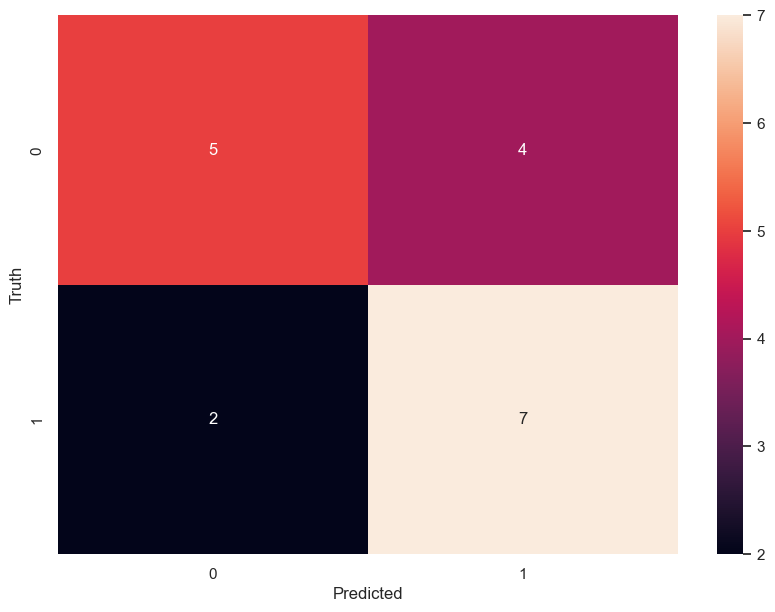

In [19]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [20]:
predicted = tf.one_hot(predicted, 2)


In [21]:
predicted

<tf.Tensor: shape=(18, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

In [22]:
# Import confusion matrix and classification report from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
Y_prediction = svc.predict(x_test1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predicted,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(target[indexes_test], Y_pred_classes) 
print(classification_report(target[indexes_test], Y_pred_classes))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63         9
           1       0.64      0.78      0.70         9

    accuracy                           0.67        18
   macro avg       0.68      0.67      0.66        18
weighted avg       0.68      0.67      0.66        18



In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, auc

C:\Users\achin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


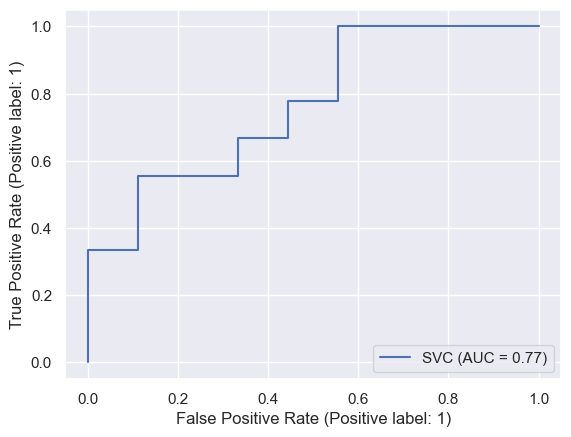

In [24]:
plot_roc_curve(svc, x_test1, y_test)

In [25]:
# Get data path
data_path = 'final data/*.nii.gz'
# Find all files within the location that matches our search string
files = glob.glob(data_path)

# Get the labels for our data from our csv file
Labels = pd.read_csv('labels.csv')
# Define our target from the column "Labels" as our y in our model
target = Labels['group']

In [26]:
# Loop through files and load all data files
data_all, images = [], []
for data_file in sorted(files):
    data = nib.load(data_file).get_fdata()
    first_vol = data[:,:,:,0]
    first = first_vol / 255
    data_all.append(first)
    
# Convert our list into a numpy array
images = np.asarray(data_all)

print(len(data_all))
print (np.shape(images))

120
(120, 64, 64, 34)


In [27]:
# Create list of indices
N = images.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:60]
con = indexes[60:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.7 * size)
split_2 = int(0.85 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = images[indexes_train, ...]
X_val = images[indexes_val, ...]
X_test = images[indexes_test, ...]
print(X_train.shape, X_val.shape,X_test.shape)

(84, 64, 64, 34) (18, 64, 64, 34) (18, 64, 64, 34)


In [28]:
print(indexes_train_dis.shape, indexes_train_con.shape)
print(indexes_val_dis.shape, indexes_val_con.shape)
print(indexes_test_dis.shape, indexes_test_con.shape)

(42,) (42,)
(9,) (9,)
(9,) (9,)


In [29]:
# Create outcome variable for each set (training, validation and test)
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(84, 64, 64, 34)
(18, 64, 64, 34)
(18, 64, 64, 34)
(84,)
(18,)
(18,)


In [30]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('int32')
y_test = np.asarray(y_test).astype('int32')
y_val = np.asarray(y_val).astype('int32')

In [31]:
y_train = tf.one_hot(y_train, 2)
y_test = tf.one_hot(y_test, 2)
y_val = tf.one_hot(y_val, 2)
print(y_val) 

tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(18, 2), dtype=float32)


In [32]:
x_train = X_train.reshape(len(X_train), -1)
print(x_train.shape)
x_test = X_test.reshape(len(X_test), -1)
print(x_test.shape)
x_val = X_val.reshape(len(X_val), -1)
print(x_val.shape)

(84, 139264)
(18, 139264)
(18, 139264)


In [33]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train1 = sc.fit_transform(x_train)
x_test1 = sc.transform(x_test)
x_val1 = sc.transform(x_val)

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(solver='svd', shrinkage=None, priors=None, n_components=1, store_covariance=False, tol=0.0001)
x_train1 = lda.fit_transform(x_train1, np.argmax(y_train, axis =1))
x_test1 = lda.transform(x_test1)
x_val1 = lda.transform(x_val1)

In [35]:
#ANN code

model = keras.Sequential([
    keras.layers.Flatten(input_shape= x_train1[0].shape),
    keras.layers.Dense(500, kernel_initializer= "uniform",  activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(500, kernel_initializer= "uniform", activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(500, kernel_initializer= "uniform", activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model.summary()
model.fit(x_train1, y_train, validation_data=(x_val1, y_val) ,epochs=100, batch_size=12)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 500)               1000      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0

Epoch 49/100
7/7 [==============================] - 0s 12ms/step - loss: 0.4346 - accuracy: 0.8214 - val_loss: 0.6795 - val_accuracy: 0.5556
Epoch 50/100
7/7 [==============================] - 0s 13ms/step - loss: 0.4235 - accuracy: 0.8333 - val_loss: 0.6621 - val_accuracy: 0.6111
Epoch 51/100
7/7 [==============================] - 0s 15ms/step - loss: 0.4385 - accuracy: 0.8333 - val_loss: 0.6604 - val_accuracy: 0.6111
Epoch 52/100
7/7 [==============================] - 0s 18ms/step - loss: 0.4899 - accuracy: 0.8452 - val_loss: 0.7181 - val_accuracy: 0.6111
Epoch 53/100
7/7 [==============================] - 0s 22ms/step - loss: 0.4750 - accuracy: 0.8095 - val_loss: 0.7088 - val_accuracy: 0.6111
Epoch 54/100
7/7 [==============================] - 0s 18ms/step - loss: 0.4597 - accuracy: 0.8333 - val_loss: 0.6366 - val_accuracy: 0.6111
Epoch 55/100
7/7 [==============================] - 0s 18ms/step - loss: 0.4493 - accuracy: 0.8333 - val_loss: 0.6689 - val_accuracy: 0.5556
Epoch 56/100


In [36]:
model.evaluate(x_test1, y_test)

1/1 [==============================] - 0s 63ms/step - loss: 0.6798 - accuracy: 0.7222


[0.6797848343849182, 0.7222222089767456]

In [37]:
# Analyze prediction values



predicted = model.predict(x_test1)
predicted[:,:]

1/1 [==============================] - 0s 234ms/step


array([[0.80782795, 0.19217212],
       [0.83856547, 0.16143452],
       [0.02654145, 0.9734586 ],
       [0.9673717 , 0.03262829],
       [0.9571502 , 0.0428498 ],
       [0.804408  , 0.19559203],
       [0.94925165, 0.05074833],
       [0.87232476, 0.12767525],
       [0.89364654, 0.10635354],
       [0.02289643, 0.9771036 ],
       [0.95997125, 0.04002871],
       [0.9657444 , 0.03425561],
       [0.03118405, 0.9688159 ],
       [0.9420548 , 0.05794522],
       [0.94338906, 0.05661093],
       [0.11003529, 0.8899647 ],
       [0.03952335, 0.96047664],
       [0.09405074, 0.90594923]], dtype=float32)

In [38]:
# Import confusion matrix and classification report from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
Y_prediction = model.predict(x_test1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predicted,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(target[indexes_test], Y_pred_classes) 
print(classification_report(target[indexes_test], Y_pred_classes))

1/1 [==============================] - 0s 67ms/step
              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.83      0.56      0.67         9

    accuracy                           0.72        18
   macro avg       0.75      0.72      0.71        18
weighted avg       0.75      0.72      0.71        18



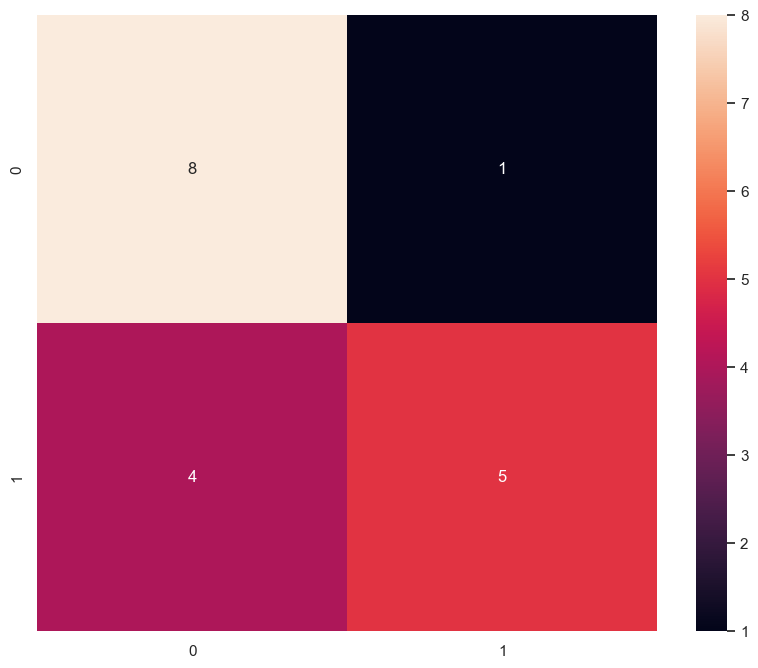

In [39]:
# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

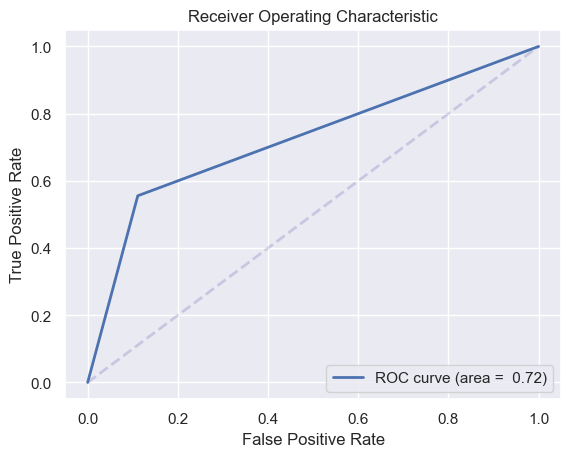

In [40]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.argmax(y_test, axis =1), np.argmax(predicted, axis =1), pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

lw = 2
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.15)
plt.plot(fpr, tpr, lw=lw, label=f'ROC curve (area = {roc_auc: 0.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()